In [294]:
import sys
#!{sys.executable} -m pip install scikit-beam
#!{sys.executable} -m pip install numba

import functions
import xpcs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
from scipy.optimize import curve_fit as fit
from scipy import signal
from scipy.fftpack import fft2, fftshift

#!{sys.executable} -m pip install lmfit
#!{sys.executable} -m pip install jscatter
from jscatter.formel import schulzDistribution
from jscatter.formel import pDA
from jscatter.formfactor import sphere

#import skbeam.core.correlation as corr
#import skbeam.core.roi as roi
#import skbeam.core.utils as utils

from dls_data_extraction import*
from integrators import *
#from utilities import *
#from corrections import *
#from masking_streaks import *
#from mask_tools import *

import time
date = time.strftime("%Y-%m-%d")
datadir = './tmp/'+date+'/' # define path for saving data

In [295]:
# experimental parameters
downsample=1
distance = 4.0 # m
photon_energy = 10.0e3 # eV
h = 4.135667696e-15 # eV*s
c = 2.99792458e8 # m/s
wavelength = h*c / photon_energy # m
pix = 55e-6 # m
center_x, center_y = 1069.5//downsample, 201.5//downsample
center = center_y, center_x 

In [296]:
def angular_integration(img, roi_img, downsample, n_bins):
    
    # --- simple angular integration based on circles around the center

    dpix = downsample*pix
    mask_thr = 0

    # angular intregation
    qbin,Iq = angular_average(img,center,mask=roi_img,threshold=mask_thr, nx=n_bins) # ph/pix

    # convert radius to q
    rs = qbin*dpix
    tth = np.arctan2(rs, distance)
    q = 4.0e-9 * np.pi / wavelength * np.sin(0.5*tth) # 1/nm
    print(q[-1])

    return q, Iq

# Sample - NP in water

In [323]:
sample = '100NP_water'
scans = 252
exp_time = 1
downsample = 1
center_x, center_y = 1069.5, 201.5 # original
rois = [(0//downsample, 250//downsample)] # single ring 1x1 binning

roi_img = xpcs.make_roi(center_x, center_y, rois, downsample)
frames = xpcs.make_frames('/data/visitors/nanomax/20210623/2021052608/raw/sample/tristan-%04d*' %scans, 
                     exp_time, roi_img, downsample)
img = xpcs.make_img(frames[0])/exp_time # ph/s  
print('done')

done


## Q-map

(515, 2069)
[]


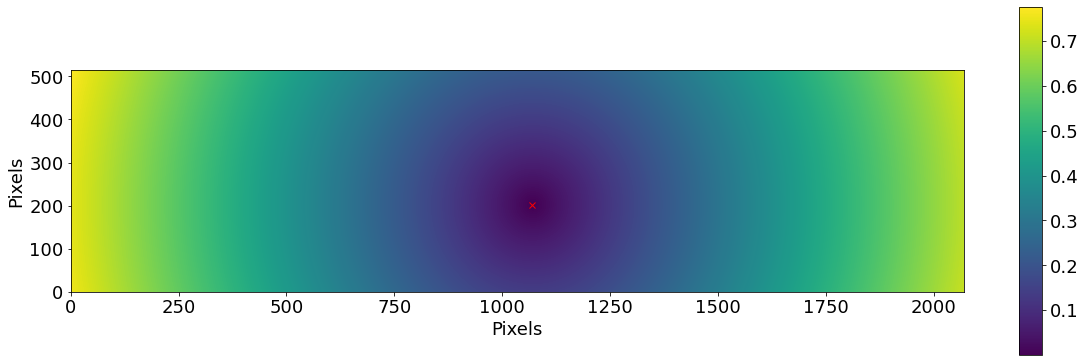

In [299]:
# make grid
x = np.arange(0,img.shape[1])
y = np.arange(0,img.shape[0])
xx,yy = np.meshgrid(x,y)
r = (((xx-center_x)**2 + (yy-center_y)**2 ) ** 0.5)
rs = r*pix
tth = np.arctan2(rs, distance)
Q = 4.0e-9 * np.pi / wavelength * np.sin(0.5*tth) # 1/nm

# Q-map
plt.figure(figsize=(20,8))
plt.imshow(Q, origin='lower') # 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.show()

0.173854069626969
0.04878933269782034 0.17469024796804417
181


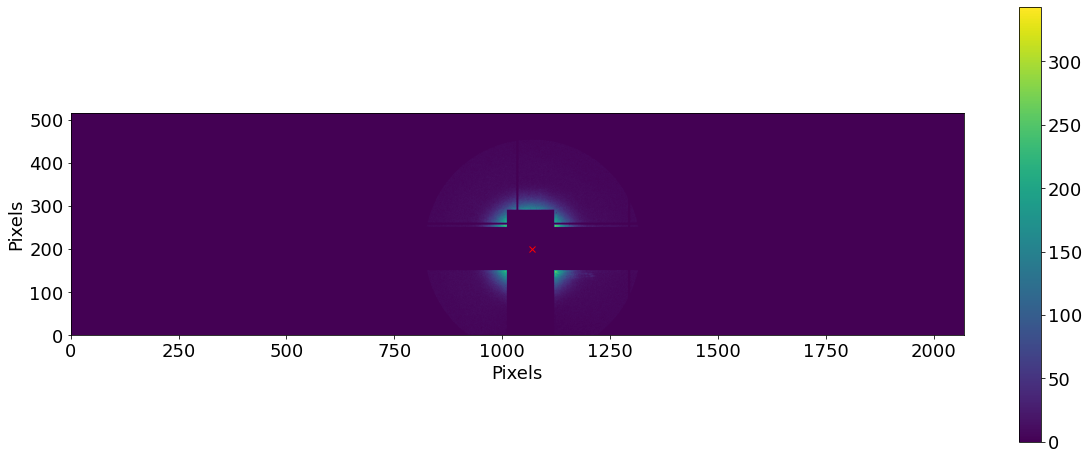

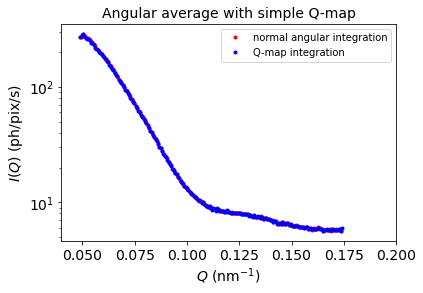

In [300]:
plt.figure(figsize=(20,8))
plt.imshow(img, origin='lower')
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])

q1, Iq1 = angular_integration(img, roi_img, downsample, n_bins=(rois[0][1]-rois[0][0])//downsample) # simple angular integration
Q_av, I_av = functions.calc_Iq(Q, img, roi_img, downsample, nbins=200, n_max=250, n_min=center_y, threshold=0) # Q-map integration

plt.figure()
plt.plot(q1[1:],Iq1[1:],'r.', label='normal angular integration')
plt.plot(Q_av[1:],I_av[1:],'b.', label='Q-map integration')
plt.ylabel(r'$I(Q)$ (ph/pix/s)', size=14)
plt.xlabel(r'$Q$ $\rm(nm^{-1})$', size=14)
plt.title('Angular average with simple Q-map',size=14)
plt.legend()
plt.tick_params(labelsize=14)
plt.xlim([0.04,0.2])
plt.yscale('log')

plt.show()

# Model form factor

In [301]:
R =  55 # radius, nm
sigma = 0.2 # fraction polydispersity
    
ff = np.empty((y[-1]+1,x[-1]+1))
ff_broad = np.empty((y[-1]+1,x[-1]+1))
ff_small = np.empty((y[-1]+1,x[-1]+1))
ff_large = np.empty((y[-1]+1,x[-1]+1))
for i in range(0,y[-1]):
    ff[i,:] = pDA(sphere, R*sigma, 'radius', type='Schulz', q=Q[i,:], radius=R).Y # 1D intensity based on the particle form factor
    #ff_broad[i,:] = pDA(sphere, 66*0.1, 'radius', type='Schulz', q=Q[i,:], radius=66).Y # 1D intensity based on the particle form factor
    #ff_small[i,:] = pDA(sphere, R/2*sigma, 'radius', type='Schulz', q=Q[i,:], radius=R/2).Y # 1D intensity based on the particle form factor
    #ff_large[i,:] = pDA(sphere, R*2*sigma, 'radius', type='Schulz', q=Q[i,:], radius=R*2).Y # 1D intensity based on the particle form factor

ff_norm = ff/np.sum(ff) # normalize it
#ff_broad_norm = ff_broad/np.sum(ff_broad) # normalize it
#ff_small_norm = ff_small/np.sum(ff_small) # normalize it
#ff_large_norm = ff_large/np.sum(ff_large) # normalize it

514


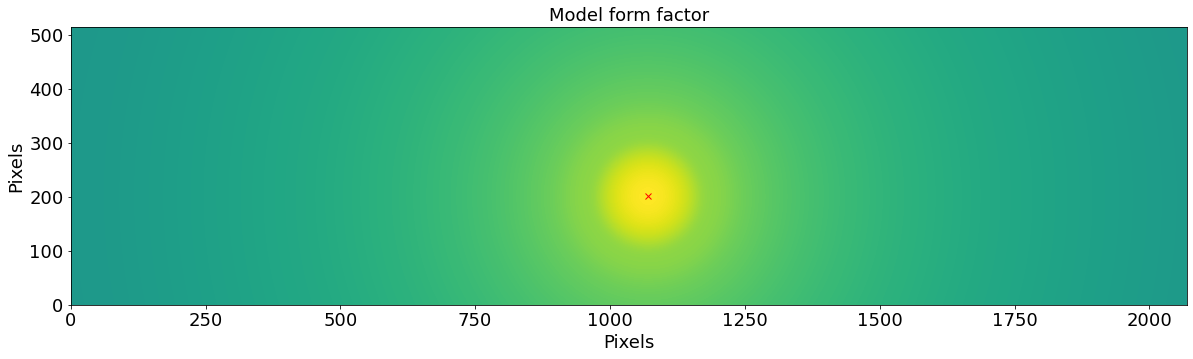

0.173854069626969


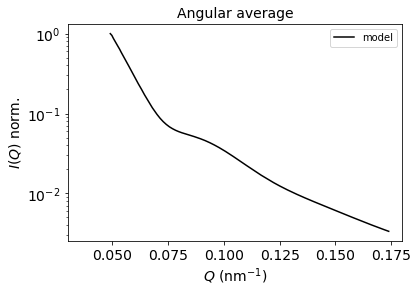

In [302]:
I0 = ff_norm

plt.figure(figsize=(20,8))
plt.imshow(I0, origin='lower', norm=matplotlib.colors.LogNorm()) 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Model form factor', size=18)

q_m, Iq_m = angular_integration(I0, roi_img, downsample, n_bins=rois[0][1]//downsample) # form factor Iq

plt.figure()
plt.plot(q_m[1:],Iq_m[1:]/np.max(Iq_m[1:]),'k-', label='model')
plt.ylabel(r'$I(Q)$ norm.', size=14)
plt.xlabel(r'$Q$ $\rm(nm^{-1})$', size=14)
plt.title('Angular average',size=14)
plt.tick_params(labelsize=14)
plt.xlim([0.03,0.18])
plt.yscale('log')
plt.legend()

plt.show()

# Model beam

In [303]:
# beam divergence
divergence = 1.2e-3 # divergence, rad
s1 = 88e-9 # focus size, m
s2 = np.tan(divergence/2) * 2 * distance + s1 # beam size (fwhm) on detector, m
print('beam size at detector:',np.round(s2*1e3,1),'mm')

beam size at detector: 4.8 mm


## Rectangular Gaussian

43.63716887272802 21.81858443636401


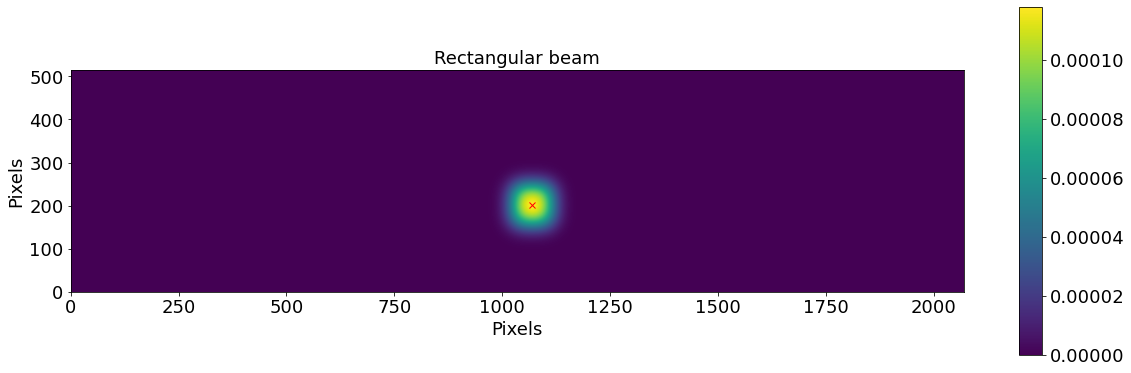

0.04878933269782034 0.17469024796804417


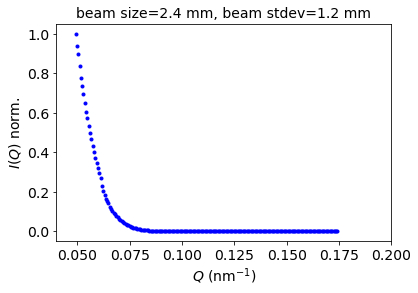

In [304]:
s = s2/pix/2 # half-beam size (fwhm) in pixels
diffuse = 2 # diffuse beam edges
print(s, s/diffuse)
rect_beam = np.zeros((515,2069))
for i in range(0,y[-1]):
    if np.abs(i-center_y) < s:
        rect_beam[i,np.int(center_x-s):np.int(center_x+s)] = np.ones(rect_beam[i,np.int(center_x-s):np.int(center_x+s)].shape) # square 
        for j in range(np.int(center_x-s),np.int(center_x+s)):
            rect_beam[i,j] = np.ones(rect_beam[i,j].shape) 
from scipy.ndimage import gaussian_filter
rect_beam = gaussian_filter(rect_beam, sigma=s/diffuse) 
rect_beam = rect_beam/np.sum(rect_beam) # normalize

plt.figure(figsize=(20,8))
plt.imshow(rect_beam, origin='lower') # 
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Rectangular beam', size=18)

q_beam, Iq_beam = functions.calc_Iq(Q, rect_beam, roi_img, downsample, nbins=200, n_max=250, n_min=center_y, threshold=0) # Q-map integration

plt.figure()
plt.plot(q_beam,Iq_beam/Iq_beam.max(),'b.')
plt.ylabel(r'$I(Q)$ norm.', size=14)
plt.xlabel(r'$Q$ $\rm(nm^{-1})$', size=14)
plt.title('beam size=%.1f mm, beam stdev=%.1f mm' %(s*pix*1e3, s/diffuse*pix*1e3),size=14)
plt.tick_params(labelsize=14)
plt.xlim([0.04,0.2])

plt.show()

# Convolution

Text(0.5, 1.0, 'Model form factor convoluted')

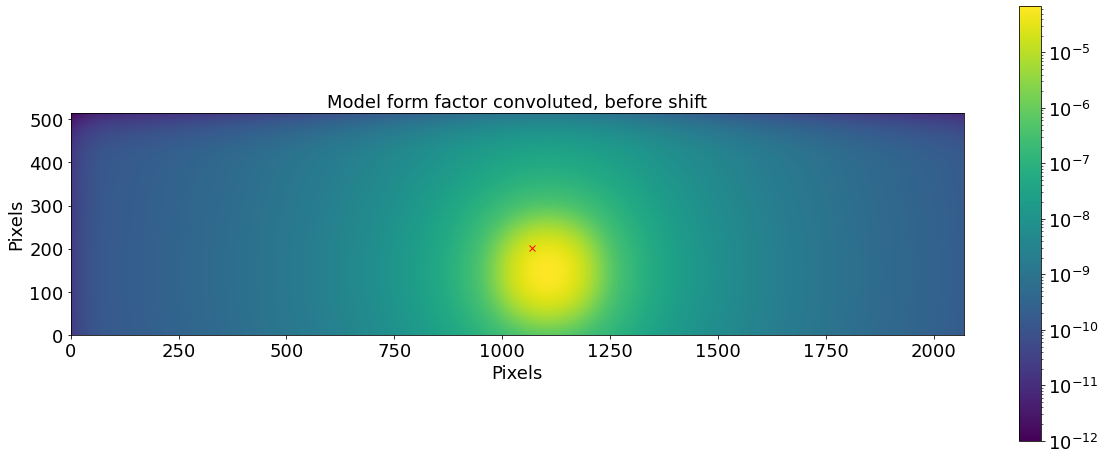

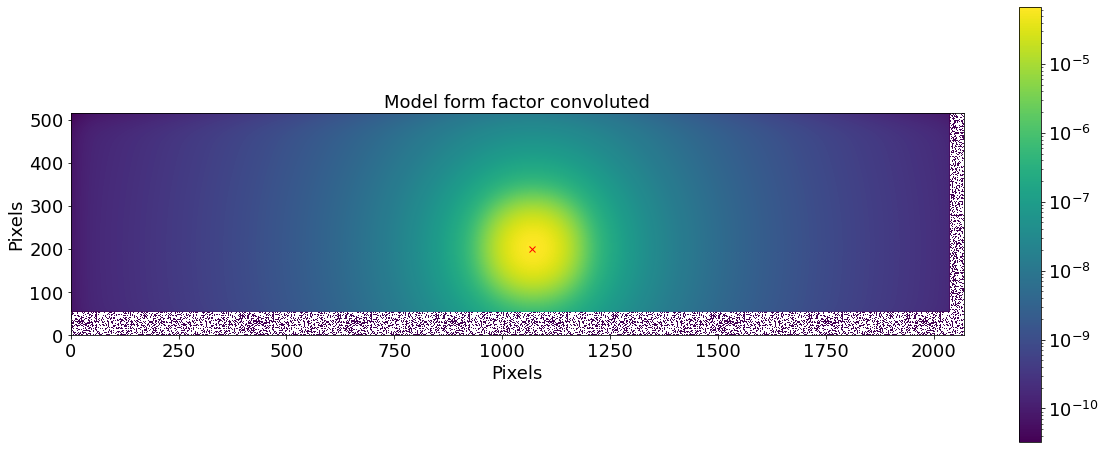

In [305]:
smallx1 = np.int((center_x-250)/downsample)
smallx2 = np.int((center_x+250)/downsample)
smally1 = np.int((center_y-140)/downsample)
smally2 = np.int((center_y+250)/downsample)

# convolve model form factor I(q) with model beam image

img_conv = signal.convolve(I0, rect_beam, mode='same')/np.sum(rect_beam) 
m = np.where(img_conv == img_conv.max()) # find the new center (i.e. the maximum)
img_conv_shift = functions.shift_image(img_conv, np.int(center_x-m[1][0]),np.int(center_y-m[0][0])) # re-center image to the beam center
I_noshift = img_conv
I = img_conv_shift
I_norm = I/np.sum(I)

plt.figure(figsize=(20,8))
plt.imshow(img_conv, origin='lower', norm=matplotlib.colors.LogNorm()) 
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Model form factor convoluted, before shift to re-center', size=18)

plt.figure(figsize=(20,8))
plt.imshow(I, origin='lower', norm=matplotlib.colors.LogNorm()) 
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Model form factor convoluted', size=18)

plt.show()

# Q-map integration

0.1737669691579281
0.04878933269782034 0.17469024796804417
0.04878933269782034 0.17466801109666394
0.04878933269782034 0.17466801109666394


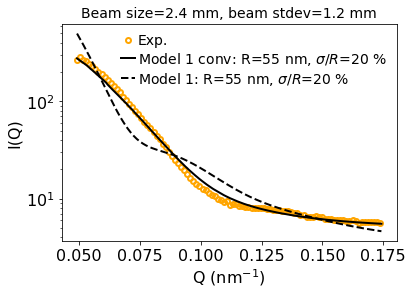

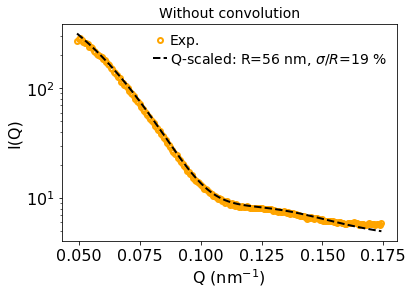

In [367]:
# experimental, normal integration (with circular rings)
frames = xpcs.make_frames('/data/visitors/nanomax/20210623/2021052608/raw/sample/tristan-%04d*' %scans, exp_time, roi_img, downsample)
img = xpcs.make_img(frames[0])/exp_time # ph/s  
q1, Iq1 = angular_integration(img, roi_img, downsample, n_bins=200)

# experimental, new integration based on normal Q-map
Q_av, I_av = functions.calc_Iq(Q, img, roi_img, downsample, nbins=200, n_max=250, n_min=center_y, threshold=0)

# model without convolution
Q_av_m0, I_av_m0 = functions.calc_Iq(Q, I0, roi_img, downsample, nbins=200, n_max=250, n_min=140, threshold=0)

# convoluted model
Q_av_m, I_av_m = functions.calc_Iq(Q, I, roi_img, downsample, nbins=200, n_max=250, n_min=140, threshold=0)
#Q_av_m, I_av_m_broad = functions.calc_Iq(Q, img_conv_shift_broad, roi_img, downsample, nbins=200, n_max=250, n_min=140, threshold=0)
#Q_av_m, I_av_m_small = functions.calc_Iq(Q, img_conv_shift_small, roi_img, downsample, nbins=200, n_max=250, n_min=140, threshold=0)
#Q_av_m, I_av_m_large = functions.calc_Iq(Q, img_conv_shift_large, roi_img, downsample, nbins=200, n_max=250, n_min=140, threshold=0)


###############################################################
# fit amplitude and background to match the experimental data:
###############################################################

from lmfit.models import Model
def normalize(x, amplitude, background): 
    return np.log10(amplitude * x + background)
model = Model(normalize) 
pars = model.make_params()
pars['amplitude'].set(1e1, min=0)
pars['background'].set(4, min=0)


# plot I(q) with convolution:

plt.figure()

plt.plot(Q_av[1::2],I_av[1::2],'o', ms=5, markeredgecolor='orange', markerfacecolor='none', markeredgewidth=2, label='Exp.')

scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=I_av_m[1:])
plt.plot(Q_av[1:],I_av_m[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value,'k-', lw=2, label='Model 1 conv: R=%.d nm, $\sigma/R$=%.d %%' %(R, sigma*100))

scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=I_av_m0[1:])
plt.plot(Q_av[1:],I_av_m0[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value,'k--', lw=2, label='Model 1: R=%.d nm, $\sigma/R$=%.d %%' %(R, sigma*100))

# plot additional model form factor (other sizes etc.)
#scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=I_av_m_broad[1:])
#plt.plot(Q_av[1:],I_av_m_broad[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value,'--', color='grey', lw=2, label='Model 2: R=%.d nm, $\sigma/R$=%.d %%' %(66, 0.1*100))

#scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=I_av_m_small[1:])
#plt.plot(Q_av[1:],I_av_m_small[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value,'b-', lw=2, label='Model 3: R=%.d nm, $\sigma/R$=%.d %%' %(R/2, sigma*100))

#scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=I_av_m_large[1:])
#plt.plot(Q_av[1:],I_av_m_large[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value,'g-', alpha=0.7, lw=2, label='Model 4: R=%.d nm, $\sigma/R$=%.d %%' %(R*2, sigma*100))

plt.xlabel('Q (nm$^{-1}$)',size=16)
plt.ylabel('I(Q)',size=16)
plt.yscale('log')
plt.title('Beam size=%.1f mm, beam stdev=%.1f mm' %(s*pix*1e3, s/diffuse*pix*1e3),size=14)
plt.tick_params(labelsize=16)
plt.legend(loc='upper right', frameon=False, prop={'size': 14}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2)

#plt.savefig('Iq_conv_'+str(scans)+'.png', dpi=300, bbox_inches='tight',) # save plot



# plot I(Q) without convolution:

plt.figure()
plt.plot(Q_av[1:], I_av[1:], 'o', ms=5, markeredgecolor='orange', markerfacecolor='none', markeredgewidth=2, label='Exp.')

ffshift = pDA(sphere, 56*0.19, 'radius', type='Schulz', q=Q_av/1.49, radius=56).Y
pars['amplitude'].set(1e-9, min=0)
scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=ffshift[1:])
plt.plot(Q_av[1:],ffshift[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value,'k--', lw=2, label='Q-scaled: R=%.d nm, $\sigma/R$=%.d %%' %(56, 0.19*100))

plt.title('Without convolution', size=14)
#plt.xlim([0.05,0.18])
plt.tick_params(labelsize=16)
plt.legend(loc='upper right', frameon=False, prop={'size': 14}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2);
plt.xlabel('Q (nm$^{-1}$)',size=16)
plt.ylabel('I(Q)',size=16)
plt.yscale('log')

#plt.savefig('Iq_no_conv_'+str(scans)+'.png', dpi=300, bbox_inches='tight',) # save plot

plt.show()

In [ ]:
# plot I(q) for paper

unit = 1e6 
binning = 10*10

# display the results
fig = plt.figure(figsize=[5,4.5])

scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=I_av_m0[1:])
Q_av_m00, I_av_m00 = functions.calc_Iq(Q, I0, None, downsample, nbins=200, n_max=400, n_min=140, threshold=0)
#plt.plot(Q_av_m00[1:],(I_av_m00[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value)/unit*binning, 'k--', lw=2, label=r'$R = %.d$ nm' %(R))
#plt.plot(Q_av_m00[1:],(I_av_m00[1:]*5.5e6 + 3.5)/unit*binning, 'k--', lw=2, label=r'$R = %.d$ nm' %(R))
plt.plot(Q_av_m00[1:],(I_av_m00[1:]*5.5e6 + 5)/unit*binning, 'k--', lw=2, label=r'$R = %.d$ nm' %(R))

pars['amplitude'].set(1e3, min=0)
pars['background'].set(4, min=0, max=100)
scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=I_av_m[1:])
Q_av_mm, I_av_mm = functions.calc_Iq(Q, I, None, downsample, nbins=200, n_max=400, n_min=140, threshold=0)
plt.plot(Q_av_mm[1:],(I_av_mm[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value)/unit*binning, 'k-', lw=2, label=r'convoluted: $R = %.d$ nm' %(R))

plt.plot(Q_av[::2],I_av[::2]/exp_time/unit*binning, 'o', ms=6, markeredgecolor='orange', markerfacecolor='none', markeredgewidth=1.5, label='data')

plt.axvspan(5.9e-2, 9.4e-2, facecolor='lightblue', alpha=0.5)

plt.ylabel('$I(Q)$ (ph/pix/$\mu$s)',size=18) # per 10x10 superpixel
plt.xlabel('$Q$ (nm$^{-1}$)',size=18)
plt.tick_params(labelsize=18)
plt.legend(loc='upper right', frameon=False, prop={'size': 14}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2);
plt.yscale('log')
plt.xlim([0e-2,18e-2])
plt.ylim([4e-4,10e-2]) 

#plt.savefig('Iq_'+sample+'_'+str(scans)+'_'+str(downsample)+'x'+str(downsample)+'_'+str(exp_time)+'s.png', dpi=300, bbox_inches='tight',) # save plot

plt.show()

## map of decay rates

D: 8.853471460100594e-13
0.0004927211788530641 0.19659711060498433
0.0004927211788530641 0.19659711060498433
511.3992957014086 23496.367070471413
0.04878933269782034 0.12455296592902522
0.04878933269782034 0.12455296592902522


/mxn/visitors/sharonb/jupyter_notebooks/functions.py:50: RuntimeWarning: Mean of empty slice.
  Q_av = np.array([Q_map_flat[inds == i].mean() for i in range(0, nbins+1)])
/mxn/visitors/sharonb/jupyter_notebooks/functions.py:51: RuntimeWarning: Mean of empty slice.
  I_av = np.array([I_map_flat[inds == i].mean() for i in range(0, nbins+1)])


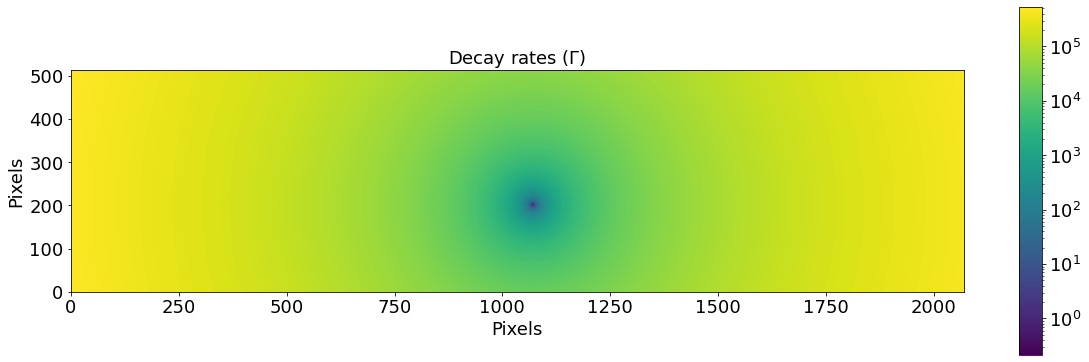

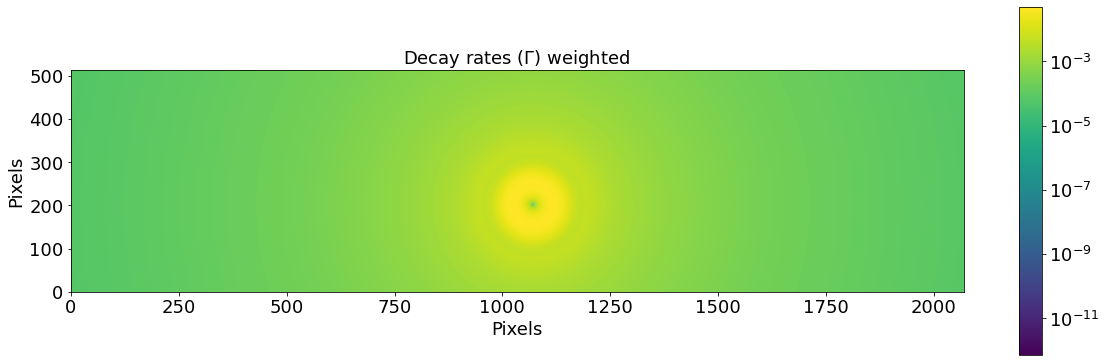

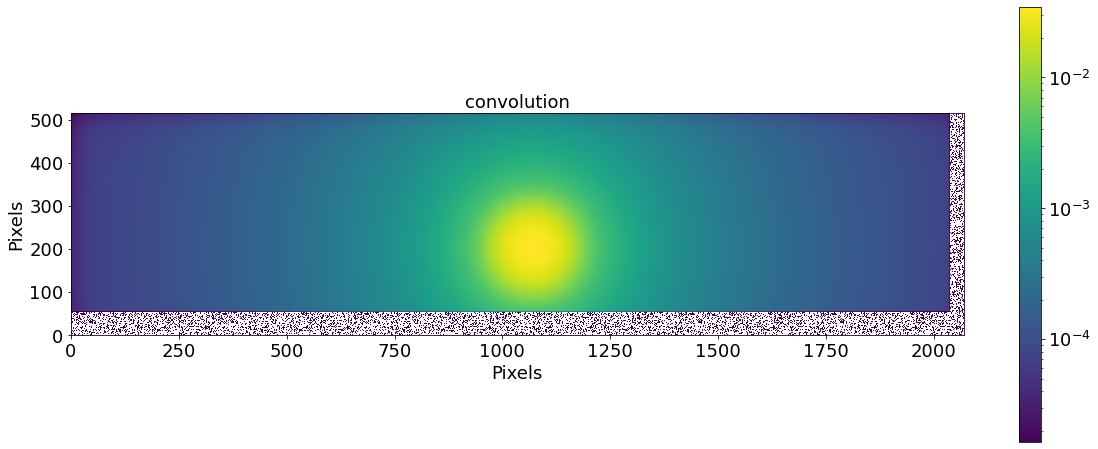

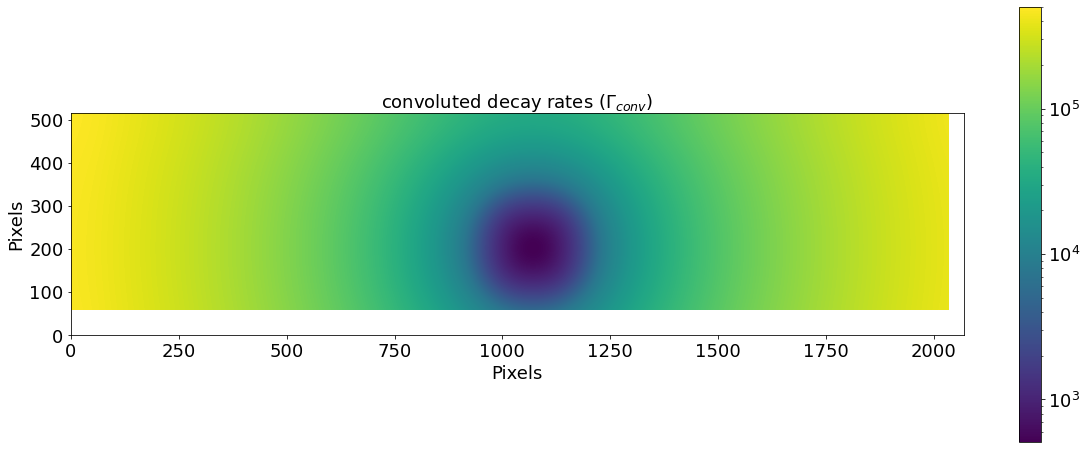

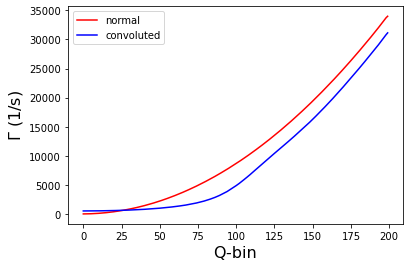

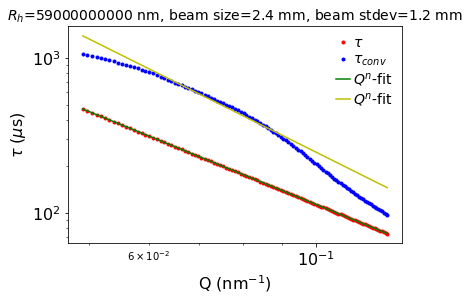

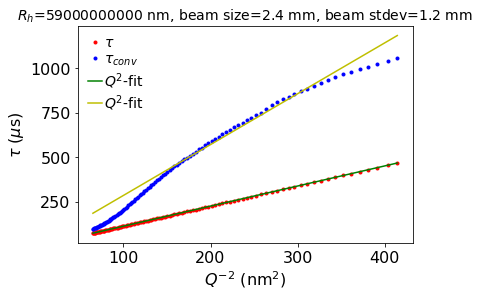

fitted Q-exponents:
normal: 1.9999876420586347 conv: 2.438867606784965
fitted D:
normal: 8.853558084814118e-13
conv: 3.497732847854962e-13
0.05874476120337961 0.09459534392188829


In [309]:
Rh = 59 # hydrodynamic radius, nm
T = 295 # K
solvent = 'dmso'

# load viscosities:
ndata_w1 = np.loadtxt('./viscositydata_dehaoui.dat', delimiter=',') # mPas, water viscosity from dehaoui et al.
ndata_w2 = np.loadtxt('./macroscopic_viscosity_water_hallet_kestin_collings.dat', delimiter=',') # mPas, macroscopic water viscosity 
ndata_w = np.vstack((ndata_w1,ndata_w2))
n_dmso = np.array([339.6, 214.7, 140.2, 43.47, 18.25, 14.27, 9.16, 6.17, 5.18, 4.383])*1e-3 # Pas, 33 mol% dmso
T_dmso = np.array([-55, -50, -45, -30, -15, -10, 0, 10, 15, 20])+273.15; # K 
popt_w,pcov_w = fit(power_law,ndata_w[:,0],ndata_w[:,1]*1e-3,p0=[1e-4, 220, 2]) # Pas, power law fit water
popt_dmso_power,pcov_dmso_power = fit(power_law,T_dmso[6:],n_dmso[6:],p0=[1e-4, 200, 3]) # Pas, power law fit dmso-water
if solvent == 'water':
    viscosity = power_law(T,*popt_w)
elif solvent == 'dmso':
    viscosity = power_law(T,*popt_dmso_power)

# calculate the decay rate map:
k = 1.38064852e-23
D = k*T/(6*np.pi*Rh*1e-9*viscosity)  # SE diffusion coefficient
print('D:',D)
Gamma0 = D*(Q*1e9)**2 # map of decay rates

plt.figure(figsize=(20,8))
plt.imshow(Gamma0, origin='lower', norm=matplotlib.colors.LogNorm()) # 
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.title(r'Decay rates ($\Gamma$)', size=18)

plt.figure(figsize=(20,8))
plt.imshow(Gamma0*I0, origin='lower', norm=matplotlib.colors.LogNorm()) # 
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.title(r'Decay rates ($\Gamma$) weighted', size=18)

# convolve with the model beam: 
X_conv = signal.convolve(Gamma0*I0, rect_beam, mode='same')/np.sum(rect_beam)  # convolute the Gamma0*I0
m = np.where(X_conv == X_conv[np.int(center_y-100):np.int(center_y+100), np.int(center_x-100):np.int(center_x+100)].max()) # find the new center 
Gamma = functions.shift_image(X_conv, np.int(center_x-m[1][0]),np.int(center_y-m[0][0]))/I # shift and divide by conv convolved model I0 (i.e. I) to retrieve the convolved intensity-weighted Gamma

plt.figure(figsize=(20,8))
plt.imshow(Gamma, origin='lower', norm=matplotlib.colors.LogNorm()) 
#plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.title(r'convoluted decay rates ($\Gamma_{conv}$)', size=18) 

plt.show()

## angular integration of the convolved decay rate map

In [ ]:
Q_av, Gamma0_av = functions.calc_Iq(Q, Gamma0, None, downsample, nbins=200, n_max=200, n_min=140, threshold=-1) # n_min=140 due to shift, to avoid the lower zero rows
Q_av, Gamma_av = functions.calc_Iq(Q, Gamma, None, downsample, nbins=200, n_max=200, n_min=140, threshold=-1) # n_min=140 due to shift, to avoid the lower zero rows

# angular integration from the center and out
plt.figure()
plt.plot(Gamma0_av[1:],'r', label='normal')
plt.plot(Gamma_av[1:],'b', label='convoluted')
plt.xlabel(r'Q-bin', size=16)
plt.ylabel(r'$\Gamma$ (1/s)', size=16)
plt.legend()

# angular integration of masked image
Q_av, Gamma0_av = functions.calc_Iq(Q, Gamma0, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0) # n_min=140 due to shift, to avoid the lower zero rows
Q_av, Gamma_av = functions.calc_Iq(Q, Gamma, roi_img, downsample, nbins=110, n_max=110, n_min=140, threshold=0) # n_min=140 due to shift, to avoid the lower zero rows
ind = np.argwhere((Q_av>0.05922907) & (Q_av<0.09406963)) # fit similar Q-range as the experimental data

# Q-exponent fit:
def tau_fit(x,a,b):
    return -a*x + b # q-dependence fit
popt, pcov = fit(tau_fit, np.log(Q_av[1:]), np.log(1/Gamma0_av[1:]), p0=[2,1]) 
popt_c, pcov_c = fit(tau_fit, np.log(Q_av[ind[0][0]-1:ind[-1][0]+1]), np.log(1/Gamma_av[ind[0][0]-1:ind[-1][0]+1]), p0=[2,1]) 

# Q^2 fit:
def tau_fit2(x,a):
    return (1/a)*x  
popt2, pcov2 = fit(tau_fit2, 1/(Q_av[1:]*1e9)**2, 1/Gamma0_av[1:], p0=[1e-12]) 
popt_c2, pcov_c2 = fit(tau_fit2, 1/(Q_av[ind[0][0]-1:ind[-1][0]+1]*1e9)**2, 1/Gamma_av[ind[0][0]-1:ind[-1][0]+1], p0=[1e-12])

# plot angular average, log Q scale
plt.figure()
plt.plot(Q_av[1:],1/Gamma0_av[1:]*1e6,'r.', label=r'$\tau$')
plt.plot(Q_av[1:],1/Gamma_av[1:]*1e6,'b.', label=r'$\tau_{conv}$')
plt.plot(Q_av[1:], np.exp(tau_fit(np.log(Q_av[1:]), *popt))*1e6,'g-', lw=1.5, label=r'$Q^n$-fit') 
plt.plot(Q_av[1:], np.exp(tau_fit(np.log(Q_av[1:]), *popt_c))*1e6,'y-', lw=1.5, label=r'$Q^n$-fit') 
plt.xlabel(r'Q (nm$^{-1}$)', size=16)
plt.ylabel(r'$\tau$ ($\mu$s)', size=16)
plt.yscale('log')
plt.xscale('log')
plt.title('$R_h$=%.d nm, beam size=%.1f mm, beam stdev=%.1f mm' %(Rh*1e9, s*pix*1e3, s/diffuse*pix*1e3),size=14)
plt.tick_params(labelsize=16)
plt.legend(loc='best', frameon=False, prop={'size': 14}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2);

# plot angular average, Q^2 dependence
plt.figure()
plt.plot(1/Q_av[1:]**2,1/Gamma0_av[1:]*1e6,'r.', label=r'$\tau$')
plt.plot(1/Q_av[1:]**2,1/Gamma_av[1:]*1e6,'b.', label=r'$\tau_{conv}$')
plt.plot(1/Q_av[1:]**2, tau_fit2(1/(Q_av[1:]*1e9)**2, *popt2)*1e6,'g-', lw=1.5, label=r'$Q^2$-fit') 
plt.plot(1/Q_av[1:]**2, tau_fit2(1/(Q_av[1:]*1e9)**2, *popt_c2)*1e6,'y-', lw=1.5, label=r'$Q^2$-fit') 
plt.xlabel(r'$Q^{-2}$ (nm$^{2}$)', size=16)
plt.ylabel(r'$\tau$ ($\mu$s)', size=16)
plt.title('$R_h$=%.d nm, beam size=%.1f mm, beam stdev=%.1f mm' %(Rh*1e9, s*pix*1e3, s/diffuse*pix*1e3),size=14)
plt.tick_params(labelsize=16)
plt.legend(loc='best', frameon=False, prop={'size': 14}, labelspacing=0.2, handletextpad=0.2, handlelength=1.0, borderpad=0.2);
plt.show()

print('fitted Q-exponents:')
print('normal:',popt[0],'conv:', popt_c[0])
print('fitted D:')
print('normal:', popt2[0])
print('conv:', popt_c2[0])
print(Q_av[ind[0][0]-1], Q_av[ind[-1][0]+1])

if solvent=='water':
    np.save('Q_av_tau_NPwater',Q_av)
    np.save('tau_av_NPwater',1/Gamma_av)
    np.save('tau0_av_NPwater',1/Gamma0_av)
elif solvent=='dmso':
    np.save('Q_av_tau_NPdmso',Q_av)
    np.save('tau_av_NPdmso',1/Gamma_av)
    np.save('tau0_av_NPdmso',1/Gamma0_av)

# Convolve Q-map with model beam

(array([146]), array([1104])) [-34.5] [55.5]
0.0004927211788530641 0.24586767281469213
0.04878933269782034 0.17466801109666394
0.029294841050146375 0.16275571737370936 0.04911938817445969 0.17426043141237837


/mxn/visitors/sharonb/jupyter_notebooks/functions.py:50: RuntimeWarning: Mean of empty slice.
  Q_av = np.array([Q_map_flat[inds == i].mean() for i in range(0, nbins+1)])
/mxn/visitors/sharonb/jupyter_notebooks/functions.py:51: RuntimeWarning: Mean of empty slice.
  I_av = np.array([I_map_flat[inds == i].mean() for i in range(0, nbins+1)])


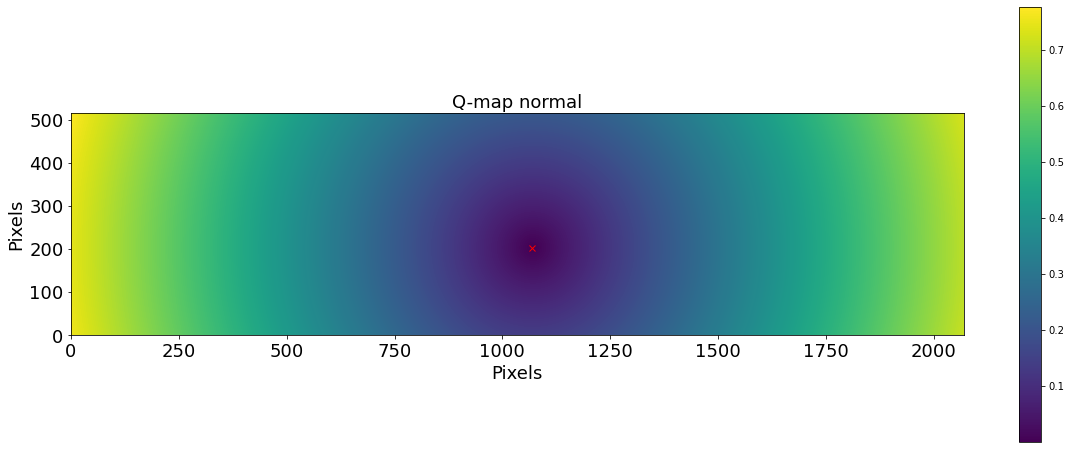

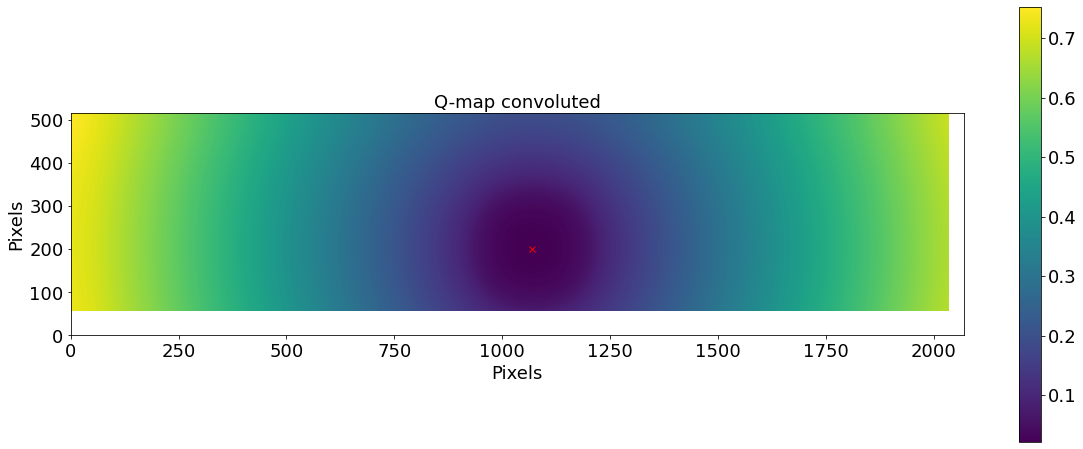

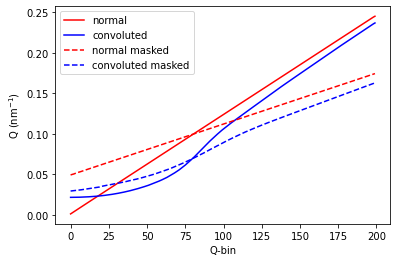

In [293]:
# convolve Q-map with model beam image 

smallx1 = np.int((center_x-250)/downsample)
smallx2 = np.int((center_x+250)/downsample)
smally1 = np.int((center_y-140)/downsample)
smally2 = np.int((center_y+250)/downsample)


Q_conv = signal.convolve(Q*I0, rect_beam, mode='same')/np.sum(rect_beam) # intensity-weighted convolution
mQ = np.where(Q_conv == Q_conv[np.int(center_y-100):np.int(center_y+100), np.int(center_x-100):np.int(center_x+100)].max()) # find the new center 
print(mQ, center_x-mQ[1], center_y-mQ[0])
Q_conv_shift = functions.shift_image(Q_conv, np.int(center_x-mQ[1][0]),np.int(center_y-mQ[0][0]))/I # re-center image to the beam center


plt.figure(figsize=(20,8))
plt.imshow(Q, origin='lower') 
plt.plot(center_x,center_y,'rx')
plt.title('Q-map normal', size=18)
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
plt.colorbar()

plt.figure(figsize=(20,8))
plt.imshow(Q_conv_shift, origin='lower') 
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Q-map convoluted', size=18)

############################################

#Q_new = Q_conv_shift[np.int(center_y), np.int(center_x):np.int(center_x)+250]
#Q_old = Q[np.int(center_y), np.int(center_x):np.int(center_x)+250]
#x_old = np.arange(len(Q_old))
#x_new = np.arange(len(Q_new))

Q_old, Q_new = functions.calc_Iq(Q, Q_conv_shift, None, downsample, nbins=200, n_max=250, n_min=140, threshold=-1) # calc Q 1d using the Q-bins from the normal Q-map

plt.figure()
plt.plot(Q_old[1:],'r', label='normal')
plt.plot(Q_new[1:],'b', label='convoluted')

Q_old, Q_new = functions.calc_Iq(Q, Q_conv_shift, roi_img, downsample, nbins=200, n_max=250, n_min=140, threshold=0) # calc Q 1d using the Q-bins from the normal Q-map

plt.plot(Q_old[1:],'r--', label='normal masked')
plt.plot(Q_new[1:],'b--', label='convoluted masked')
print(Q_new[1], Q_new[-1], Q_old[1], Q_old[-1] )

plt.xlabel('Q-bin')
plt.ylabel('Q (nm$^{-1}$)')
plt.legend()

##########################################


# Intensity-weighted radius

DLS Q-range: 66.34327309621015
Nanomax convoluted Q-range: 59.12165028077167


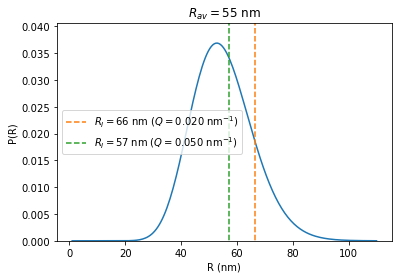

In [282]:
import jscatter as js
import scipy.integrate as integrate

radius = 55 #59 # nm, mean radius of the size distribution
sigma = 0.2*radius #0.15*radius

#radius = 63 # nm, mean radius of the size distribution
#sigma = 0.1*radius

def nom(r,q,R=radius): # nominator for intensity-weighted averaging
    SZ = js.formel.schulzDistribution(r, R, sigma) # relative number of particles with radius r
    sp = js.ff.sphere(q, r) # form factor scattering intensity
    nom = (r * SZ.Y * sp.Y) 
    return nom

def den(r,q,R=radius): # denominator for intensity-weighted averaging
    SZ = js.formel.schulzDistribution(r, R, sigma)
    sp = js.ff.sphere(q, r)
    den = (SZ.Y * sp.Y) 
    return den

def f(q):
    r1, r2 = 1.0, 200.0
    y_nom, err_nom = integrate.quad(nom, r1, r2, args=(q,))
    y_den, err_den = integrate.quad(den, r1, r2, args=(q,))
    return y_nom/y_den # intensity-weighted average R for q=q


#############################
# integrate over q-range:
a, b = 0.0177, 0.0238 # DLS q-range
y, err = integrate.quad(f, a, b)
print('DLS Q-range:',y/(b-a))

a, b = 0.03, 0.16 # nanomax convoluted q-range
y, err = integrate.quad(f, a, b)
print('Nanomax convoluted Q-range:',y/(b-a))
#############################


plt.figure()
R=radius # nm
q = np.array([0.02, 0.05]) # nm-1
r = np.linspace(1,R*2,200)
SZ = js.formel.schulzDistribution(r, R, sigma)
plt.plot(SZ.X, SZ.Y,'-')

for i in range(len(q)):
    R_int = f(q[i])
    plt.plot(np.array([R_int, R_int]), [-0.1, 1],'--', label = r'$R_{I} = %.d$ nm ($Q=%.3f$ nm$^{-1}$)' %(R_int, q[i])) # plot vertical line marking the end of the fit range

plt.xlabel('R (nm)')
plt.ylabel(r'P(R)')
plt.title(r'$R_{av} = %.d$ nm' %(R))
plt.ylim([0,np.max(SZ.Y)+0.1*np.max(SZ.Y)])
plt.legend()
         
plt.show()

# Not used

In [ ]:
# test

#R1 = 56
#sigma1 = 0.19

# form factor Iq calculated with the convoluted Q:
ff_0 = pDA(sphere, R*sigma, 'radius', type='Schulz', q=Q_old, radius=R).Y 
ff_c = pDA(sphere, R*sigma, 'radius', type='Schulz', q=Q_new, radius=R).Y 

plt.figure()
Q_av, I_av = functions.calc_Iq(Q, img, roi_img, downsample, nbins=200, n_max=250, n_min=center_y, threshold=0)
plt.plot(Q_av[1:], I_av[1:], 'o', ms=5, markeredgecolor='orange', markerfacecolor='none', markeredgewidth=2, label='Exp.')

pars['amplitude'].set(1e3, min=0)
pars['background'].set(4, min=0, max=100)
scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=I_av_m[1:])
plt.plot(Q_av[1:],(I_av_m[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value), 'k-', lw=2, label=r'conv intensity: $R = %.d$ nm' %(R))

pars['amplitude'].set(5e-10, min=0)
pars['background'].set(5, min=0, max=100)
scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=ff_0[1:])
#plt.plot(Q_av[1:],(ff_0[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value), 'r-', lw=2, label=r'normal: $R = %.d$ nm' %(R))

scale_m = model.fit(np.log10(I_av[1:]), params=pars, x=ff_c[1:])
#plt.plot(Q_av[1:],(ff_c[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value), 'b-', lw=2, label=r'conv Q: $R = %.d$ nm' %(R))

plt.plot(Q_old[1:], ff_0[1:]*5e-10+5,'r.', label='normal')
plt.plot(Q_old[1:], ff_c[1:]*5e-10+5,'b.', label='conv Q')
plt.xlabel('Q (nm$^{-1}$)')
plt.ylabel('I(Q)')
plt.yscale('log')
plt.title('R=%.d nm, $\sigma/R$=%.d %%' %(R, sigma*100),size=14)
plt.legend()
#plt.ylim([4e0,4e2])
#plt.xlim([0.04,0.2])
plt.show()

##############################

R1=66
sigma1=0.03

R2=66
sigma2=0.15

shift=0.025
ff_0 = pDA(sphere, R1*sigma1, 'radius', type='Schulz', q=Q_old, radius=R1).Y 
ff_shifted = pDA(sphere, R1*sigma1, 'radius', type='Schulz', q=Q_old+shift, radius=R1).Y 
ff_new = pDA(sphere, R2*sigma2, 'radius', type='Schulz', q=Q_old+shift, radius=R2).Y 

plt.figure()
plt.plot(Q_old, ff_0, 'r-', label='$I_1$')
plt.plot(Q_old, ff_shifted, 'b-', label='$I_2$ (shifted +0.025 nm$^{-1}$)')
plt.plot(Q_old, (ff_0+ff_shifted), 'g-', label='sum: $I_1+I_2$')
plt.plot(Q_old, ff_new, 'k--', label='$I_3$')
plt.xlabel('Q (nm$^{-1}$)')
plt.ylabel('I(Q)')
plt.yscale('log')
plt.legend()

In [ ]:
q_c, Iq_c = angular_integration(img_conv_shift, roi_img_0, downsample, center_x, center_y, n_bins=rois_0[0][1])

q = np.linspace(q_m[1],q_m[-1],100) # 1/nm
ffshift = pDA(sphere, R*sigma, 'radius', type='Schulz', q=q_m/1.49, radius=R).Y
#ffshift1 = pDA(sphere, R*sigma, 'radius', type='Schulz', q=q_m-np.abs(Q_old[-1]-Q_new[-1]), radius=R).Y
#ffshift2 = pDA(sphere, R*sigma, 'radius', type='Schulz', q=Q_new[70:], radius=R).Y
#print(len(ffshift2), len(q1[1:]), q1[1], Q_old[70])
print(len(Iq1), len(Iq_c))

###################
# normalize and subtract background:
from lmfit.models import Model
def normalize(x, amplitude, background): 
    return np.log10(amplitude * x + background)
model = Model(normalize) 
pars = model.make_params()
pars['amplitude'].set(1, min=0)
pars['background'].set(1, min=0, max=100)

scale_c = model.fit(np.log10(Iq1[1:]), params=pars, x=Iq_c[1:])
scale_m = model.fit(np.log10(Iq1[1:]), params=pars, x=Iq_m[1:])
scale_m_shift = model.fit(np.log10(Iq1[1:]), params=pars, x=Iq_m_shift[1:])

scale_ffshift = model.fit(np.log10(Iq1[1:]), params=pars, x=ffshift[1:])
#scale_ffshift1 = model.fit(np.log10(Iq1[1:]), params=pars, x=ffshift1[1:])
#scale_ffshift2 = model.fit(np.log10(Iq1[1:]), params=pars, x=ffshift2)

bg = 3.50922861 # from the fit to Iq
ampl = 9.6637e-10
###################

plt.figure(figsize=(7,5))
plt.plot(q_c[1:],Iq_c[1:]*scale_c.params['amplitude'].value + scale_c.params['background'].value,'b.', label='convolution')
plt.plot(q1[1:],Iq1[1:],'r.', label='experiment')
plt.plot(q_m[1:],Iq_m[1:]*scale_m.params['amplitude'].value + scale_m.params['background'].value,'k-', lw=2, label='model form factor')
plt.plot(q_m_shift[1:],Iq_m_shift[1:]*scale_m_shift.params['amplitude'].value + scale_m_shift.params['background'].value,'k--', lw=2, label='q-scaled model form factor')

#plt.plot(q_m[1:],ffshift[1:]*scale_ffshift.params['amplitude'].value + scale_ffshift.params['background'].value,'g--', lw=2, label='q-scaled model 2')
#plt.plot(q_m[1:],ffshift[1:]*ampl+bg,'g--', lw=2, label='q-scaled model 2')
#plt.plot(Q_old[70:],ffshift2*scale_ffshift2.params['amplitude'].value + scale_ffshift2.params['background'].value,'m--', lw=2, label='convoluted q-scaled model ff') 

plt.ylabel(r'$I(Q)$', size=18)
plt.xlabel(r'$Q$ $\rm(nm^{-1})$', size=18)
plt.title('R=%.d nm, $\sigma/R$=%.d %%, beam size=%.1f mm, beam stdev=%.1f mm' %(R, sigma*100, s*pix*1e3, s/diffuse*pix*1e3),size=14)
plt.tick_params(labelsize=18)
#plt.xlim([0.03,0.18])
#plt.ylim([1e-3,5])
plt.yscale('log')
#plt.xscale('log')
plt.legend(frameon=False, fontsize=14)
plt.show()

scale_ffshift

## Round Gaussian beam

In [ ]:
s = s2/pix/2 # half-beam size in pixels
beam = np.zeros((y[-1]+1,x[-1]+1))
for i in range(0,x[-1]):
    beam[:,i] = 1/(2*np.pi*s)*np.exp(-r[:,i]**2/(2*s**2)) # round gaussian beam
print(beam.shape)
beam_norm = beam/np.max(beam)

plt.figure(figsize=(20,8))
plt.imshow(beam_norm, origin='lower') # 
#plt.imshow(beam*roi_img, origin='lower') # show masked image
plt.plot(center_x,center_y,'rx')
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])
plt.title('Round beam', size=18)
plt.show()

q_beam, Iq_beam = angular_integration(beam, roi_img, downsample, center_x, center_y, n_bins=rois[0][1]//downsample)
plt.figure()
plt.plot(q_beam,Iq_beam,'b.')
plt.ylabel(r'$I(Q)$', size=14)
plt.xlabel(r'$Q$ $\rm(nm^{-1})$', size=14)
plt.title('Angular average',size=14)
plt.tick_params(labelsize=14)
plt.xlim([0.03,0.18])
#plt.ylim([2,4])
#plt.yscale('log')
#plt.xscale('log')
plt.show()

## Empty beam

In [ ]:
# no sample, empty beam
scans_0 = 41
exp_time_0 = 30
rois_0 = [(0//downsample, 250//downsample)] # single ring 1x1 binning
roi_img_0 = xpcs.make_roi(center_x, center_y, rois_0, downsample)
frames_0 = xpcs.make_frames('/data/visitors/nanomax/20210623/2021052608/raw/sample/tristan-%04d*' %scans_0, 
                     exp_time_0, roi_img_0, downsample)
img_0 = xpcs.make_img(frames_0[0])  
print('done')

In [ ]:
img_1 = np.roll(img_0, -182, axis=1) # shift to center

plt.figure(figsize=(20,8))
plt.imshow(img_1/exp_time_0, origin='lower') # show ring-masked image
plt.plot(center_x,center_y,'rx')
cbar = plt.colorbar()
plt.xlabel('Pixels', size=18)
plt.ylabel('Pixels', size=18)
plt.tick_params(labelsize=18)
#cbar = plt.colorbar(**dict(pad=0.05, shrink=0.8, aspect=15))
cbar.ax.tick_params(labelsize=18)
plt.xlim([0,2069//downsample])
plt.ylim([0,515//downsample])

smallx1 = np.int((center_x-100)/downsample)
smallx2 = np.int((center_x+100)/downsample)
smally1 = np.int((center_y-100)/downsample)
smally2 = np.int((center_y+100)/downsample)

plt.figure(figsize=(10,5))
plt.imshow(img_1[smally1:smally2,smallx1:smallx2]/exp_time_0, origin='lower') # show ring mask
plt.colorbar()

q0, Iq0 = angular_integration(img_0/exp_time_0, roi_img_0, downsample, center_x, center_y, n_bins=rois_0[0][1]//downsample)
print(q0[-1], Iq0[-1]/Iq0[1])
plt.figure()
plt.plot(q0,Iq0/Iq0[1],'b.')
plt.ylabel(r'$I(Q)$ (ph/pix/s)', size=14)
plt.xlabel(r'$Q$ $\rm(nm^{-1})$', size=14)
plt.title('Angular average',size=14)
plt.tick_params(labelsize=14)
plt.xlim([0.03,0.18])
#plt.ylim([2,4])
plt.yscale('log')
#plt.xscale('log')

plt.show()

In [485]:
Rp = 500e-9
R = 1e-7/2 # m
d = 1e-3 # m
c = 0.48/100 
Vp = 4*np.pi*Rp**3/3

V = np.pi*R**2*d
N = c*V/Vp

print(N)

n = 1.002e-3 
k = 1.38e-23
T=295
D = k*T/(6*np.pi*n*Rp)
print(D)

S = 2*np.pi*R*d
S/D # s

0.072
4.310843468576886e-13


728.7651886434442

4.310843468576886e-13


7287.651886434442